In [23]:
import numpy as np
import pygsti
from pygsti.tools import print_mx as pmx
#from pygsti.modelpacks import smq1Q_XY as std
from pygsti.modelpacks import smq1Q_XYZI as std
import random
from tqdm import tqdm
import cvxpy as cp

import matplotlib.pyplot as plt

In [24]:
tgt = std.target_model()

In [25]:
tgt.operations

OrderedMemberDict([(Label(()),
                    <pygsti.modelmembers.operations.fullarbitraryop.FullArbitraryOp at 0x7f73c65b3640>),
                   (Label(('Gxpi2', 0)),
                    <pygsti.modelmembers.operations.fullarbitraryop.FullArbitraryOp at 0x7f73c65b3760>),
                   (Label(('Gypi2', 0)),
                    <pygsti.modelmembers.operations.fullarbitraryop.FullArbitraryOp at 0x7f73c65b37c0>),
                   (Label(('Gzpi2', 0)),
                    <pygsti.modelmembers.operations.fullarbitraryop.FullArbitraryOp at 0x7f73c65b3b20>)])

In [29]:
tgt[('Gzpi2', 0)].to_dense()

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.23711432e-17],
       [ 0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.23711432e-17,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [2]:
def random_circuit(depth, proc_spec):
    """
    works for any 1-qubit model pack and the XYZICnot 2-qubit pack
    """
    layers = []
    for i in range(depth):
        gate = random.choice(proc_spec.gate_names)
        if gate == '(idle)':
            pass
        elif gate == 'Gcnot':
            layers.append((gate, 0, 1))
        else:
            layers.append((gate, random.choice(proc_spec.qubit_labels)))
    return Circuit(layers, proc_spec.qubit_labels)

In [3]:
def calculate_jacobs(circ_list, model):
    jacobs = {}
    for circ in circ_list:
        hilbert_dims = 2**circ.width
        jacobs[circ] = matrix_from_jacob(model.sim.dprobs(circ), hilbert_dims)
    return jacobs

In [4]:
def project_to_psd(matrix):
    x = cp.Variable(matrix.shape)
    objective = cp.Minimize(cp.norm(x - matrix, 'fro'))
    constraints = [x >= 0]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return x.value

In [5]:
def is_psd(matrix):
    eigs = np.linalg.eigvals(matrix)
    if np.any(eigs < 0):
        return False
    else:
        return True

In [6]:
from pygsti.report import reportables as rptbl

basis = pygsti.baseobjs.Basis.cast("pp",4) # 1-qubit Pauli basis (2x2 matrices)

from pygsti.tools import jamiolkowski_iso, jamiolkowski_iso_inv


def avg_gs_fidelity(model, noise_model, qubits=1):
    aei = 0
    basis = pygsti.baseobjs.Basis.cast("pp",4**qubits) # 1-qubit Pauli basis (2x2 matrices)
    for op in list(model.operations.keys()):
        mdl_mat = model[op].to_dense()
        #choi_mat = jamiolkowski_iso(mdl_mat)
        #if not is_psd(choi_mat):
        #    choi_mat = project_to_psd(choi_mat)
        #    mdl_mat = jamiolkowski_iso_inv(choi_mat)
        aei += rptbl.entanglement_fidelity(mdl_mat, noise_model[op].to_dense(), basis)
    return aei/len(list(model.operations.keys()))

def avg_gs_dd(model, noise_model):
    add = 0
    for op in list(model.operations.keys()):
        add += rptbl.half_diamond_norm(model[op].to_dense(), noise_model[op].to_dense(), basis)
    return add/len(list(model.operations.keys()))

In [7]:
def vector_from_outcomes(outcomes, num_outcomes):
    vecout = np.zeros((num_outcomes))
    for key in outcomes.keys():
        vecout[int(key[0], 2)] = outcomes[key]
    return(vecout)

def matrix_from_jacob(jacob, num_outcomes):
    matout = np.zeros((num_outcomes, len(jacob['0'*int(np.log2(num_outcomes))])))
    for key in jacob.keys():
        matout[int(key[0], 2), :] = np.array(jacob[key])
    return matout

def tensor_from_hessian(hessian, hilbert_dims):
    """
    returns a 3d-array that when dotted into the state returns the jacobian 
    """
    num_params = len(hessian['0'*int(np.log2(hilbert_dims))])
    tensor_out = np.zeros((hilbert_dims, num_params, num_params))
    for key in hessian.keys():
        tensor_out[int(key[0], 2), :, :] = hessian[key]
    return tensor_out

In [8]:
def make_multinom_covar(prob_vec):
    return np.diag(prob_vec) - np.outer(prob_vec, prob_vec)

def make_dirichlet_covar(counts, hilbert_dims):
    total_counts = sum([counts[key] for key in counts.keys()])    
    count_vec = np.ones(hilbert_dims)
    for key in counts.keys():
        count_vec[int(key[0], 2)] += counts[key]
    prefactor = 1/( (total_counts + hilbert_dims)**2 * (total_counts + hilbert_dims + 1) )
    meas_covar = prefactor*(
        (total_counts + hilbert_dims)*np.diag(count_vec) - np.outer(count_vec, count_vec)
    )
    return meas_covar

In [9]:
class LinearKalmanFilter():
    def __init__(self, x0, P0):
        self.x0 = x0
        self.num_params = len(x0)
        self.P = P0
        
    def update(self, circ, count_vec, p_target, jacob, clip_range, Q=None, R_additional=None):        
        hilbert_dims = 2**(circ.width)

        # 1) calculate your frequency
        total_counts = sum(count_vec)
        observation = count_vec/total_counts

        # 2) calculate the covariance of the observation and add model noise
        mean_frequency = ( count_vec+np.ones(len(count_vec)) )/( sum(count_vec)+len(count_vec) )
        R = (1/(total_counts))*make_multinom_covar(mean_frequency)
        if R_additional is not None:
            R += R_additional
        if Q is None: 
            Q = 0*np.eye(self.num_params)

        # 3) Kalman Predict and Update
        P = self.P + Q

        Kgain = P@jacob.T@np.linalg.pinv(jacob@P@jacob.T + R, 1e-6)
        innovation = observation - p_target
        self.x0 = self.x0 + Kgain@innovation
        self.P = (np.eye(self.num_params) - Kgain@jacob)@P
        self.x0 = np.clip(self.x0, clip_range[0], clip_range[1])
        return Kgain

In [10]:
class ExtendedKalmanFilter():
    def __init__(self, model, P0):
        self.model = model
        self.num_params = len(model.to_vector())
        self.P = P0
        
    def update(self, circ, count_vec, clip_range, max_itr=1, itr_eps=1e-4, Q=None, R_additional=None):
        prior_covar = self.P
        prior_state = self.model.to_vector()
        
        for itr in range(max_itr):
            hilbert_dims = 2**(circ.width)

            # 0) find the predicted frequency for the circuit outcome under the model
            probs = self.model.probabilities(circ)
            p_model = vector_from_outcomes(probs, hilbert_dims)

            # calculate jacobian
            # jacob = jac0 + hessian@prior_state
            jacob = matrix_from_jacob(self.model.sim.dprobs(circ), 2**circ.width)
        
            # 1) calculate your frequency
            total_counts = sum(count_vec)
            observation = count_vec/total_counts

            # 2) calculate the covaraiance of the observation and add model noise
            mean_frequency = ( count_vec+np.ones(len(count_vec)) )/( sum(count_vec)+len(count_vec) )
            R = (1/(total_counts))*make_multinom_covar(mean_frequency)
            if R_additional is not None:
                R += R_additional
            if Q is None: 
                Q = 0*np.eye(self.num_params)

            # 3) Kalman Predict and Update
            P = prior_covar + Q
            
            Kgain = P@jacob.T@np.linalg.pinv(jacob@P@jacob.T + R, 1e-15)
            innovation = observation - p_model
            post_state = prior_state + Kgain@innovation
            post_state = np.clip(post_state, clip_range[0], clip_range[1])
            if np.linalg.norm(post_state - prior_state) < itr_eps:
                break
            prior_state = post_state
            self.model.from_vector(post_state)
            
        self.P = (np.eye(self.num_params) - Kgain@jacob)@P
        self.model.from_vector(post_state)
        return Kgain
    
    def update_approx(self, circ, count_vec, p0, jac0, hessian, clip_range, max_itr=1, itr_eps=1e-4, Q=None, R_additional=None):
        prior_covar = self.P
        prior_state = self.model.to_vector()
        
        for itr in range(max_itr):
            hilbert_dims = 2**(circ.width)

            # 0) find the predicted frequency for the circuit outcome under the model
            # probs = self.model.probabilities(circ)
            p_model = p0 + jac0@prior_state + prior_state@hessian@prior_state

            # calculate jacobian
            jacob = jac0 + hessian@prior_state
                    
            # 1) calculate your frequency
            total_counts = sum(count_vec)
            observation = count_vec/total_counts

            # 2) calculate the covaraiance of the observation and add model noise
            mean_frequency = ( count_vec+np.ones(len(count_vec)) )/( sum(count_vec)+len(count_vec) )
            R = (1/(total_counts))*make_multinom_covar(mean_frequency)
            if R_additional is not None:
                R += R_additional
            if Q is None: 
                Q = 0*np.eye(self.num_params)

            # 3) Kalman Predict and Update
            P = prior_covar + Q
            
            Kgain = P@jacob.T@np.linalg.pinv(jacob@P@jacob.T + R, 1e-15)
            innovation = observation - p_model
            post_state = prior_state + Kgain@innovation
            post_state = np.clip(post_state, clip_range[0], clip_range[1])
            if np.linalg.norm(post_state - prior_state) < itr_eps:
                break
            prior_state = post_state
            self.model.from_vector(post_state)
            
        self.P = (np.eye(self.num_params) - Kgain@jacob)@P
        self.model.from_vector(post_state)
        return Kgain
        
#     def update_from_counts(self, circ, count_vec, jac0, hessian, max_itr=1, itr_eps=1e-4, Q=None, R_additional=None):
#         prior_covar = self.P
#         prior_state = 1.5*self.model.to_vector()
        
#         for itr in range(max_itr):
#             hilbert_dims = 2**(circ.width)

#             # 0) find the predicted frequency for the circuit outcome under the model
#             probs = self.model.probabilities(circ)
#             p_model = vector_from_outcomes(probs, hilbert_dims)

#             # calculate jacobian
#             jacob = (sum(count_vec)+len(count_vec))*(jac0 + hessian@prior_state)

#             # calculate the covaraiance of the observation and add model noise
#             mean_frequency = ( count_vec+np.ones(len(count_vec)) )/( sum(count_vec)+len(count_vec) )
#             R = (sum(count_vec) + len(count_vec))*make_multinom_covar(mean_frequency)
            
#             if R_additional is not None:
#                 R += R_additional
#             if Q is None: 
#                 Q = 1e-15*np.eye(self.num_params)

#             # 3) Kalman Predict and Update
#             P = prior_covar + Q
            
#             Kgain = 0.1*P@jacob.T@np.linalg.pinv(jacob@P@jacob.T + R, 1e-9)
#             innovation = count_vec - sum(count_vec)*p_model
            
#             post_state = prior_state + Kgain@innovation
#             post_state = np.clip(post_state, 0, 1)
#             if np.linalg.norm(post_state - prior_state) < itr_eps:
#                 break
#             prior_state = post_state
#             self.model.from_vector(post_state)
            
#         self.P = (np.eye(self.num_params) - Kgain@jacob)@P
#         self.model.from_vector(post_state)

In [11]:
# for saving
import pickle

def pickle_dict(obj, filename):
    with open(filename + '.pickle', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def load_dict(filename):
    with open(filename + '.pickle', 'rb') as f:
        return pickle.load(f)


In [12]:
def display_model(mdl, include_fogv=False):
    """
    
    """
    labels = mdl.fogi_errorgen_component_labels(include_fogv, typ='normal')
    coeffs = mdl.to_vector()
    if include_fogv:
        coeffs = np.hstack([coeffs, np.zeros(len(labels)-len(coeffs))])
    #coeffs = gst_mdl.fogi_errorgen_components_array(include_fogv)
    print("\n".join(["%d: %s = %g" % (i,lbl,coeff) for i,(lbl,coeff) in enumerate(zip(labels, coeffs))]))

## Plotting functions

In [13]:
def make_infidel_plot(model_vectors, data_covars, filter_model, target_model, mle_fits, plt_title, point_samples=32, plt_spacing=25):   
    fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
    

    for i in tqdm(range(0, num_circs, plt_spacing)):
        filter_model.from_vector(model_vectors[i])
        fidel = np.clip(avg_gs_fidelity(filter_model, target_model), 0, 1)
        mean_infidel = np.log10(1 - fidel)

        for s in range(point_samples):
            x0 = np.random.multivariate_normal(model_vectors[i], data_covars[i])
            filter_model.from_vector(x0)
            fidel = np.clip(avg_gs_fidelity(filter_model, target_model), 0, 1)
            infidel = np.log10(1 - fidel)
            plt.scatter(i, infidel, c='black', alpha=0.5)

        ax.scatter(i, mean_infidel, c='red')

    i = num_circs-1
    filter_model.from_vector(model_vectors[i])
    fidel = np.clip(avg_gs_fidelity(filter_model, target_model), 0, 1)
    mean_infidel = np.log10(1 - fidel)

    for s in range(point_samples):
        x0 = np.random.multivariate_normal(model_vectors[i], data_covars[i])
        filter_model.from_vector(x0)
        fidel = np.clip(avg_gs_fidelity(filter_model, target_model), 0, 1)
        infidel = np.log10(1 - fidel)
        plt.scatter(i, infidel, c='black', alpha=0.5)

    ax.scatter(i, mean_infidel, c='red')
    
    for i, fit in enumerate(mle_fits):
        mle_infidel = np.log10(1-avg_gs_fidelity(fit, target_model))
        ax.plot(gst_circuit_ranges[i], (mle_infidel, mle_infidel), c='green')


    ax.set_title(plt_title)
    ax.set_xlabel('Circuit index')
    ax.set_ylabel('AGSI (log)')

In [14]:
gst_circuit_ranges = {
    0 : [0, 92], 
    1 : [93, 168], 
    2 : [169, 285], 
    3 : [286, 448], 
    4 : [449, 616]
}



def make_error_plot(plt_title, model_vectors, true_params, filter_covars, mle_estimates, plt_spacing=25):
    fig, axs = plt.subplots(1, 2)
    
    fig.suptitle(plt_title)

    axs[0].set_title('Estimate')
    axs[1].set_title('Uncertainty')

    for i in tqdm(range(0, num_circs, plt_spacing)):
        params = model_vectors[i]
        error = np.log10(np.sqrt( (params-true_params)@(params-true_params)))
        axs[0].scatter(i, error, c='black')
        axs[1].scatter(i, np.log10(np.sqrt(np.trace(filter_covars[i]))), c='black')
        
    for i, mdl in enumerate(mle_estimates):
        mle_error = np.log10(np.sqrt( (mdl.to_vector()-true_params)@(mdl.to_vector()-true_params)))
        axs[0].plot(gst_circuit_ranges[i], (mle_error, mle_error), c='red')
        
    axs[0].set_xlabel('Circuit Index')
    axs[1].set_xlabel('Circuit Index')
    axs[0].set_ylabel('MSE [log]')
    
def make_error_estimate_plot(plt_title, model_vectors, true_params, mle_estimates, plt_spacing=25):
    fig, axs = plt.subplots(1, 1)
    
    axs.set_title(plt_title)

    for i in tqdm(range(1, num_circs, plt_spacing)):
        params = model_vectors[i]
        error = np.log10(np.sqrt( (params-true_params)@(params-true_params)))
        axs.scatter(i, error, c='black')
        
    for i, mdl in enumerate(mle_estimates):
        mle_error = np.log10(np.sqrt( (mdl.to_vector()-true_params)@(mdl.to_vector()-true_params)))
        axs.plot(gst_circuit_ranges[i], (mle_error, mle_error), c='red')
        
    axs.set_xlabel('Circuit Index')
    axs.set_ylabel('MSE [log]')

In [15]:
def point_order_statistics(mean, samples):
    num_samples = len(samples)
    
    # put into sorted and shifted form
    sorted_samples = np.sort(samples)
    shifted_samples = sorted_samples - mean
    
    # find the index of the sign change 
    sign_index = 0
    for i in range(0, num_samples):
        if shifted_samples[i] < 0 and shifted_samples[i+1] > 0:
            sign_index = i
            break
    
    # find the 1st std dev
    index_low = sign_index
    index_high = sign_index
    while (index_high - index_low) <= 0.68*num_samples:
        if index_low != 0:
            index_low -= 1
        if index_high != num_samples:
            index_high += 1
    first_index_low = index_low
    first_index_high = index_high
    
    while (index_high - index_low) <= 0.95*num_samples:
        if index_low != 0:
            index_low -= 1
        if index_high != num_samples:
            index_high += 1
    second_index_low = index_low
    second_index_high = index_high
    
    return ((shifted_samples[first_index_low], shifted_samples[first_index_high-1]), (shifted_samples[second_index_low], shifted_samples[second_index_high-1]))

def make_infidel_color_plot(model_vectors, filter_model, target_model, mle_fits, plt_title, point_samples=100, plt_spacing=25):   
    """
    colored band with dark between 1 standard dev., light between 95% confidence, and line for mean 
    """
    fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
    
    means = []
    sample_list = []
    

    for i in tqdm(range(0, num_circs, plt_spacing)):
        filter_model.from_vector(model_vectors[i])
        fidel = np.clip(avg_gs_fidelity(filter_model, target_model), 0, 1)
        mean_infidel = np.log10(1 - fidel)
        means.append(mean_infidel)
        
        samples = []
        for s in range(point_samples):
            x0 = np.random.multivariate_normal(model_vectors[i], data_covars[i])
            filter_model.from_vector(x0)
            fidel = np.clip(avg_gs_fidelity(filter_model, target_model), 0, 1)
            infidel = np.log10(1 - fidel)
            samples.append(infidel)
            #plt.scatter(i, infidel, c='black', alpha=0.5)
        sample_list.append(np.array(samples))

        #ax.scatter(i, mean_infidel, c='red')

    # get the last point
    i = num_circs-1
    filter_model.from_vector(data_model_vectors[i])
    fidel = np.clip(avg_gs_fidelity(filter_model, target_model), 0, 1)
    mean_infidel = np.log10(1 - fidel)
    means.append(mean_infidel)

    samples = []
    for s in range(point_samples):
        x0 = np.random.multivariate_normal(model_vectors[i], data_covars[i])
        filter_model.from_vector(x0)
        fidel = np.clip(avg_gs_fidelity(filter_model, target_model), 0, 1)
        infidel = np.log10(1 - fidel)
        samples.append(infidel)
        #plt.scatter(i, infidel, c='black', alpha=0.5)
    sample_list.append(np.array(samples))
    
    for idx, mean in enumerate(means):
        (first_points, second_points) = point_order_statistics(mean, sample_list[idx])
        plt.scatter(idx, mean, c='yellow')
        plt.scatter(idx, first_points[0], c='blue')
        plt.scatter(idx, first_points[1], c='blue')
        
    
    
    
    for fit in mle_fits:
        mle_infidel = np.log10(1-avg_gs_fidelity(fit, target_model))
        ax.plot((0, num_circs), (mle_infidel, mle_infidel), c='black')


    ax.set_title(plt_title)
    ax.set_xlabel('Circuit index')
    ax.set_ylabel('AGSI (log)')

In [16]:
from pygsti.processors import CliffordCompilationRules as CCR

def make_rb_param(noise_model, model_pack, length_powers=5, circuits_at_length=10):
    pspec = model_pack.processor_spec()
    
    depths = [2**i for i in range(length_powers)]
    
    compilations = {'absolute': CCR.create_standard(pspec, 'absolute', ('paulis', '1Qcliffords'), verbosity=0),            
                'paulieq': CCR.create_standard(pspec, 'paulieq', ('1Qcliffords', 'allcnots'), verbosity=0)}

    design = pygsti.protocols.DirectRBDesign(model_pack.processor_spec(), compilations, depths, circuits_at_length, qubit_labels=model_pack.processor_spec().qubit_labels, sampler='edgegrab', 
                                           samplerargs=[0.5], randomizeout=True,
                                           citerations=20)
    pygsti.io.write_empty_protocol_data(design, 'RB_Data', clobber_ok=True)
    pygsti.io.fill_in_empty_dataset_with_fake_data(noise_model, 'RB_Data/data/dataset.txt', num_samples=1000)
    data = pygsti.io.load_data_from_dir('RB_Data')
    protocol = pygsti.protocols.RB()
    results = protocol.run(data)
    return (results.fits['full'].estimates['r'], data)

In [17]:
# for saving
import pickle

def pickle_dict(obj, filename):
    with open(filename + '.pickle', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def load_dict(filename):
    with open(filename + '.pickle', 'rb') as f:
        return pickle.load(f)

In [18]:
# extended setup
def setup_extended(covar_strength, x0, target_model):
    P = covar_strength*np.eye(len(x0))
    filter_model = target_model.copy()
    filter_model.from_vector(x0)
    return ExtendedKalmanFilter(filter_model, P.copy())

In [19]:
def make_mle_estimates(mdl_datagen, target_mdl, max_lengths, samples, seed=2022):
    proto = pygsti.protocols.GST(target_mdl, gaugeopt_suite=None, verbosity=1)
    estimates = []
    edesigns = []
    for l in max_lengths:
        edesign = std.create_gst_experiment_design(l)
        ds = pygsti.data.simulate_data(mdl_datagen, edesign, samples, seed=seed) #, sample_error='none')
        data = pygsti.protocols.ProtocolData(edesign, ds)
        results_after = proto.run(data)
        fit = results_after.estimates['GateSetTomography'].models['final iteration estimate']
        estimates.append(fit)
        edesigns.append(edesign)
    return estimates, ds, edesigns

In [20]:
def mserror(mdl, target_model):
    evec = mdl.to_vector() - target_model.to_vector()
    return evec.T@evec

----
# start main file 
----

# Model setup

In [21]:
samples = 256
NPSEED = 1
max_fogi_error_rate = 0.003

In [22]:
#mdl_datagen = std.target_model().depolarize(op_noise=0.01, spam_noise=0.05)
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
np.random.seed(NPSEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)


edesign = std.create_gst_experiment_design(8)
ds = pygsti.data.simulate_data(mdl_datagen, edesign, samples, seed=2022) #, sample_error='none')
data = pygsti.protocols.ProtocolData(edesign, ds)

datagen_2dlogl = pygsti.tools.two_delta_logl(mdl_datagen, ds)
print("Datagen 2dlogl = ", datagen_2dlogl)

Datagen 2dlogl =  495.8236109714416


In [ ]:
s

In [23]:
# sim_type = 'matrix'
# gst_mdl = std.target_model("H+s")
# print("Before FOGI reparam, Np = ", gst_mdl.num_params)

# gst_mdl.sim = sim_type
# proto = pygsti.protocols.GST(gst_mdl, gaugeopt_suite=None, verbosity=1)
# results_before = proto.run(data)

In [24]:
sim_type = 'matrix'

gst_mdl = std.target_model("H+s")
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, gst_mdl.state_space, elementary_errorgen_types='HS')
gst_mdl.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
gst_mdl.sim = sim_type
# print("After FOGI reparam, Np = ", gst_mdl.num_params)


# proto = pygsti.protocols.GST(gst_mdl, gaugeopt_suite=None, verbosity=1)
# results_after = proto.run(data)

In [25]:
target_model = gst_mdl.copy()
target_model.from_vector(np.zeros(target_model.num_params))
filter_model = target_model.copy()

In [26]:
display_model(target_model)

0: H(X:0)_[] = 0
1: H(Y:0)_[] = 0
2: H(Z:0)_[] = 0
3: S(X:0)_[] = 0
4: S(Y:0)_[] = 0
5: S(Z:0)_[] = 0
6: H(X:0)_Gxpi2:0 = 0
7: S(X:0)_Gxpi2:0 = 0
8: (0.5 S(Y:0) + 0.5 S(Z:0))_Gxpi2:0 = 0
9: H(Y:0)_Gypi2:0 = 0
10: (0.5 S(X:0) + 0.5 S(Z:0))_Gypi2:0 = 0
11: S(Y:0)_Gypi2:0 = 0
12: ga(-H(Z:0))_Gypi2:0 - ga(-H(Z:0))_Gxpi2:0 = 0
13: ga(H(Y:0))_rho0 - ga(H(Y:0))_Gxpi2:0 = 0
14: ga(-H(Y:0))_Mdefault - ga(-H(Y:0))_Gxpi2:0 = 0
15: ga(H(X:0))_rho0 - ga(H(X:0))_Gypi2:0 = 0
16: ga(-H(X:0))_Mdefault - ga(-H(X:0))_Gypi2:0 = 0
17: ga(-0.5 S(X:0) - 0.5 S(Y:0))_Mdefault - ga(-0.5 S(X:0) - 0.5 S(Y:0))_rho0 = 0


In [27]:
print("datagen to target AGSI ", avg_gs_fidelity(target_model, mdl_datagen))

datagen to target AGSI  0.9976126252399892


---

In [28]:
# #calculate jacobians and hessians

# edesign = std.create_gst_experiment_design(16)

# jdict = dict()
# hdict = dict()

# for circ_list in edesign.circuit_lists:
#     for circ in tqdm(circ_list):
#         jdict[circ] = matrix_from_jacob(target_model.sim.dprobs(circ), 2**circ.width)
#         hdict[circ] = tensor_from_hessian(target_model.sim.hprobs(circ), 2**circ.width)
        
# pickle_dict(jdict, 'IXY_jacs')
# pickle_dict(hdict, 'IXY_hess')

shots---

In [30]:
filter_model.to_vector()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [31]:
rb_param = make_rb_param(mdl_datagen, std)[0]
print(rb_param, np.sqrt(rb_param))

- Sampling 10 circuits at DRB length 1 (1 of 5 depths) with seed 26104
- Sampling 10 circuits at DRB length 2 (2 of 5 depths) with seed 26114
- Sampling 10 circuits at DRB length 4 (3 of 5 depths) with seed 26124
- Sampling 10 circuits at DRB length 8 (4 of 5 depths) with seed 26134
- Sampling 10 circuits at DRB length 16 (5 of 5 depths) with seed 26144


/home/jpmarceaux/Applications/pyGSTi/pygsti/io/writers.py:505: UserWarning: write_empty_protocol_data has recently changed its signature - it looks like you need to swap the first two arguments.  Continuing using the old signature...
  _warnings.warn(("write_empty_protocol_data has recently changed its signature - it looks like you need to swap"
/home/jpmarceaux/Applications/pyGSTi/pygsti/io/writers.py:626: UserWarning: fill_in_empty_dataset_with_fake_data has recently changed its signature - it looks like you need to swap the first two arguments.  Continuing using the old signature...
  _warnings.warn(("fill_in_empty_dataset_with_fake_data has recently changed its signature - it looks like"
/home/jpmarceaux/Applications/pyGSTi/pygsti/layouts/evaltree.py:183: UserWarning: Created an evaluation tree that is inefficient: tree-size > 3 * #circuits !
This is likely due to the fact that the circuits being simulated do not have a
periodic structure. Consider using a different forward simulat

0.056782942685001614 0.238291717617297


# Example 1

Various initial points for a fixed FOGI model with 256 shots

In [32]:
mle_estimates, data, edesigns = make_mle_estimates(mdl_datagen, target_model, [1, 2, 4, 8, 16], samples)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.4s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.2s


In [38]:
print([avg_gs_fidelity(mdl, mdl_datagen) for mdl in mle_estimates])
print([mserror(mdl, mdl_datagen) for mdl in mle_estimates])
print(mserror(target_model, mdl_datagen))

[1.0000548754755323, 0.9991196535228397, 0.9998824131421853, 0.9998578081562005, 0.999927154567649]
[0.0005019307521756024, 0.00023519334108163117, 5.027402588679614e-05, 1.3310178804920844e-05, 7.876385251473181e-06]
3.42971240521657e-05


In [ ]:
# 3 exact extended filters with different start points
x0_zero = np.zeros(len(filter_model.to_vector()))
print(x0_zero)
x0_mle = mle_estimates[0].to_vector()
x0_bad = abs(np.random.multivariate_normal(np.zeros(filter_model.num_params), 0.01*np.eye(filter_model.num_params)))

covar_strength = 0.00001

zero_ekf = setup_extended(covar_strength, x0_zero, target_model)
mle1_ekf = setup_extended(covar_strength, x0_mle, target_model)
gaussian_ekf = setup_extended(covar_strength, x0_bad, target_model)



max_itr = 1
max_itr_epsilon = 1e-4

Q_add = 0*np.eye(len(filter_model.to_vector()))
R_add = 0*np.eye(2)

# run zero filter and make data
zero_model_vectors = dict()
zero_covars = dict()
mle1_model_vectors = dict()
mle1_covars = dict()
gaussian_model_vectors = dict()
gaussian_covars = dict()

idx = 0
zero_model_vectors[idx] = zero_ekf.model.to_vector()
zero_covars[idx] = zero_ekf.P
mle1_model_vectors[idx] = mle1_ekf.model.to_vector()
mle1_covars[idx] = zero_ekf.P
gaussian_model_vectors[idx] = gaussian_ekf.model.to_vector()
gaussian_covars[idx] = zero_ekf.P
idx += 1

# run over the largest set of GST circuits
for circ_list in [edesigns[-1].circuit_lists[-1]]:
    for circ in tqdm(circ_list):
        counts = data[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        #req = cvec/sum(cvec)

        #_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
        #ata_prior_innnovs[idx] = freq - p_filter_prior

        _ = zero_ekf.update(circ, cvec, [-1, 1], max_itr, max_itr_epsilon, Q_add, R_add)
        _ = mle1_ekf.update(circ, cvec, [-1, 1], max_itr, max_itr_epsilon, Q_add, R_add)
        _ = gaussian_ekf.update(circ, cvec, [-1, 1], max_itr, max_itr_epsilon, Q_add, R_add)
        #kgain = ekf.update_approx(circ, cvec, jdict[circ], hdict[circ], max_itr, max_itr_epsilon, Q_add, R_add)

        zero_model_vectors[idx] = zero_ekf.model.to_vector()
        zero_covars[idx] = zero_ekf.P
        mle1_model_vectors[idx] = mle1_ekf.model.to_vector()
        mle1_covars[idx] = mle1_ekf.P
        gaussian_model_vectors[idx] = gaussian_ekf.model.to_vector()
        gaussian_covars[idx] = gaussian_ekf.P

        #p_filter_post = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
        #data_post_innovs[idx] = freq - p_filter_post 
        idx += 1
num_circs = idx

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 336/616 [00:46<00:55,  5.09it/s]

In [168]:
plt_spacing = 20
%matplotlib inline
from matplotlib import cm

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 360.11it/s]


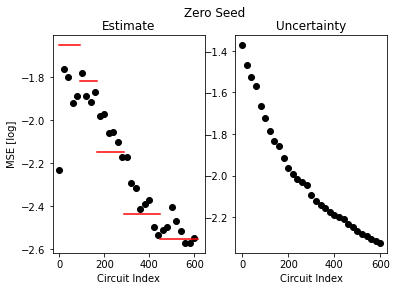

In [169]:
make_error_plot('Zero Seed', zero_model_vectors, mdl_datagen.to_vector(), zero_covars, mle_estimates, plt_spacing)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 366.64it/s]


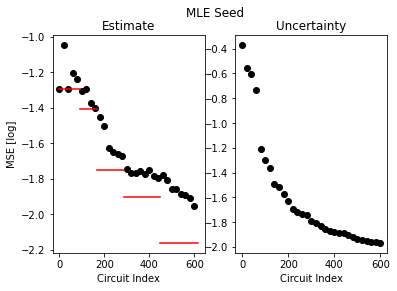

In [99]:
make_error_plot('MLE Seed', mle1_model_vectors, mdl_datagen.to_vector(), mle1_covars, mle_estimates, plt_spacing)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 348.30it/s]


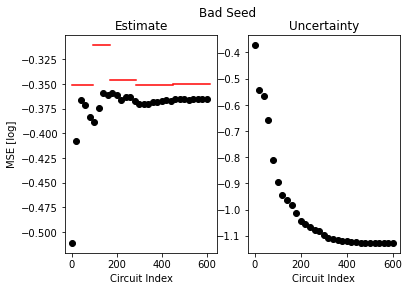

In [73]:
make_error_plot('Bad Seed', gaussian_model_vectors, mdl_datagen.to_vector(), gaussian_covars, mle_estimates, plt_spacing)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 132.50it/s]


Text(0, 0.5, 'Error')

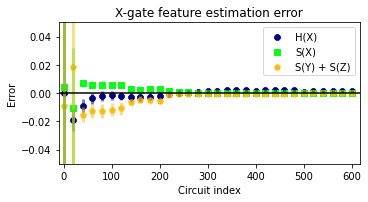

In [42]:
# X-gate convergence plot 
Xgate_errors = {
    6 : 'H(X)', 
    7 : 'S(X)',
    8 : 'S(Y) + S(Z)'
}

markers = {
    6 : '8', 
    7 : 's',
    8 : 'p',
}


fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

ideal_params = mdl_datagen.to_vector()

for i in tqdm(range(0, num_circs, plt_spacing)):
    params = mle1_model_vectors[i]
    
    for idx in Xgate_errors.keys():
        c = (idx-6)/3.2
        total_error = params[idx] - ideal_params[idx]
        ax.scatter(i, total_error, color=cm.get_cmap('gist_ncar')(c), marker=markers[idx])
        ax.errorbar(i, total_error, yerr=np.sqrt(mle1_covars[i][idx, idx]), color=cm.get_cmap('gist_ncar')(c), lw=3, alpha=0.5)
    
ax.legend(Xgate_errors.values())

ax.set_axisbelow(True)
ax.plot((-20, num_circs), (0, 0), c='black')


ax.set_ylim([-0.05, 0.05])
ax.set_xlim([-10, num_circs])
ax.set_title('X-gate feature estimation error')
ax.set_xlabel('Circuit index')
ax.set_ylabel('Error')

  0%|                                                                                                                                                                                                                 | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_25283/3828402980.py:8: RuntimeWarning: divide by zero encountered in log10
  mean_infidel = np.log10(1 - fidel)
/tmp/ipykernel_25283/3828402980.py:14: RuntimeWarning: divide by zero encountered in log10
  infidel = np.log10(1 - fidel)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.35it/s]
/tmp/ipykernel_25283/3828402980.py:34: RuntimeWarning: invalid value encountered in log10
  mle_infidel = np.log10(1-avg_gs_fidelity(fit, target_model))


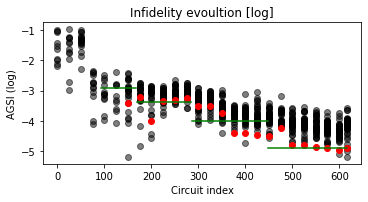

In [43]:
make_infidel_plot(mle1_model_vectors, mle1_covars, filter_model, mdl_datagen, mle_estimates, 'Infidelity evoultion [log]')

In [44]:
make_infidel_color_plot(data_model_vectors, filter_model, mdl_datagen, mle_estimates, 'Infidelity evoultion [log]')

NameError: name 'data_model_vectors' is not defined

---
# Example 2: Scaling performance

In [33]:
error_strengths = [0.01, 0.0001, 0.00001]
np.random.seed(1)

In [34]:
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
datagen_models = []
estimates = []
data_sets = []
edesign_sets = []
for e in error_strengths:
    ar = e * np.random.rand(len(ar))
    mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)
    datagen_models.append(mdl_datagen.copy())
    est, ds, edesigns = make_mle_estimates(mdl_datagen, target_model, [1, 2, 4, 8, 16], samples)
    estimates.append(est)
    data_sets.append(ds)
    edesign_sets.append(edesigns)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 3.0s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 3.9s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 6.3s
--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 2.3s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 3.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative

In [35]:
edesign = edesign_sets[-1][-1]

In [36]:
p_targets = dict()
for circ in tqdm(edesign.circuit_lists[-1]):
    p_targets[circ] = vector_from_outcomes(target_model.probabilities(circ), 2**circ.width)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:05<00:00, 110.10it/s]


In [45]:
jdict = load_dict('KalmanPaperFiles/smq1Q_XYI_jacs')
hdict = load_dict('KalmanPaperFiles/smq1Q_XYI_hess')

In [37]:
print([mserror(target_model, datagen_models[i]) for i in range(3)])

[0.0003810791561351745, 6.559399164625332e-08, 5.76937887906357e-10]


In [38]:
fidels = [avg_gs_fidelity(target_model, datagen_models[i]) for i in range(3)]
print(fidels)

[0.992048394871659, 0.9998666222325459, 0.9999847271883247]


In [47]:
covar_strength=0.01

Q_add = 0*np.eye(len(filter_model.to_vector()))
R_add = 0*np.eye(2)
max_itr = 1
max_itr_epsilon = 1e-6

extended_data = []
fast_data = []

# run over the largest set of GST circuits
for idx_error, e in enumerate(error_strengths):
    extended_model_vectors = dict()
    extended_covars = dict()
    fast_model_vectors = dict()
    fast_covars = dict()
    
    num_params = len(target_model.to_vector())
    x0 = np.zeros(num_params)
    ekf = setup_extended(covar_strength, x0, target_model)
    fekf = setup_extended(covar_strength, x0, target_model)
    
    idx_circ = 0
    # extended_model_vectors[idx_circ] = ekf.model.to_vector()
    # extended_covars[idx_circ] = ekf.P
    # fast_model_vectors[idx_circ] = fekf.model.to_vector()
    # fast_covars[idx_circ] = fekf.P
    # idx_circ += 1
    
    for circ in tqdm(edesign.circuit_lists[-2]):
        counts = data_sets[idx_error][circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        freq = cvec/sum(cvec)

        ekf.update(circ, cvec, [-1, 1], max_itr, max_itr_epsilon, Q_add, R_add)
        fekf.update_approx(circ, cvec, p_targets[circ], jdict[circ], hdict[circ], [-1, 1], max_itr, max_itr_epsilon, Q_add, R_add)

        extended_model_vectors[idx_circ] = ekf.model.to_vector()
        extended_covars[idx_circ] = ekf.P
        fast_model_vectors[idx_circ] = fekf.model.to_vector()
        fast_covars[idx_circ] = fekf.P
        idx_circ += 1
    extended_data.append((extended_model_vectors, extended_covars))
    fast_data.append((fast_model_vectors, fast_covars))
num_circs = idx_circ-1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:40<00:00, 11.00it/s]


In [ ]:
# run over the largest set of GST circuits

num_params = len(target_model.to_vector())
x0 = np.zeros(num_params)
fekf = setup_extended(covar_strength, x0, target_model)
for circ in tqdm(edesign.circuit_lists[-1]):
    counts = data_sets[idx_error][circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    freq = cvec/sum(cvec)

    fekf.update_approx(circ, cvec, p_targets[circ], jdict[circ], hdict[circ], [-1, 1], max_itr, max_itr_epsilon, Q_add, R_add)

In [48]:
%matplotlib qt5

In [49]:
i = 1
make_error_estimate_plot(f'Fast Extended Filter with AGSF = {fidels[i]:.5f}', fast_data[i][0], datagen_models[i].to_vector(), estimates[i], plt_spacing=10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 342.11it/s]


In [ ]:
make_error_estimate_plot(f'Exact Extended Filter with AGSF = {fidels[i]:.5f}', extended_data[i][0], datagen_models[i].to_vector(), estimates[i], plt_spacing=10)

----
# 2-qubit example

In [74]:
from pygsti.modelpacks import smq2Q_XYCNOT as std

In [107]:
samples = 256
#samples = 256
NPSEED = 1
max_noise_rate = 0.025

In [76]:
#mdl_datagen = std.target_model().depolarize(op_noise=0.01, spam_noise=0.05)
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)

In [77]:
target_model = mdl_datagen.copy()
print(mdl_datagen.num_params)
edesign = std.create_gst_experiment_design(max_max_length=1, fpr=True)

144


In [35]:
# # calculate jacobians and hessians
# jdict = dict()
# hdict = dict()

# for circ_list in edesign.circuit_lists:
#     for circ in t qdm(circ_list):
#         jdict[circ] = matrix_from_jacob(target_model.sim.dprobs(circ), 2**circ.width)
#         hdict[circ] = tensor_from_hessian(target_model.sim.hprobs(circ), 2**circ.width)
        
# pickle_dict(jdict, 'smq2Q_XYCNOT_jacs')
# pickle_dict(hdict, 'smq2Q_XYCNOT_hess')

In [116]:
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
np.random.seed(NPSEED)
ar = max_noise_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [118]:
mle_estimates, data, edesigns = make_mle_estimates(mdl_datagen, target_model, [1, 2, 4], samples)

--- Iterative GST: [##################################################] 100.0%  731 circuits ---
Iterative GST Total Time: 32.8s
--- Iterative GST: [##################################################] 100.0%  1509 circuits ---
Iterative GST Total Time: 48.7s
--- Iterative GST: [##################################################] 100.0%  2999 circuits ---
Iterative GST Total Time: 71.9s


In [148]:
print(mserror(target_model, mdl_datagen))
print(mserror(mle_estimates[0], mdl_datagen))
print(mserror(mle_estimates[-1], mdl_datagen))

0.029993236365641912
0.03610091120182495
0.009137545990977457


In [155]:
avg_gs_fidelity(target_model, mdl_datagen, 2)

0.8759162291194894

In [149]:
p_targets = dict()
for circ in tqdm(edesign.circuit_lists[-1]):
    p_targets[circ] = vector_from_outcomes(target_model.probabilities(circ), 2**circ.width)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [00:02<00:00, 250.24it/s]


In [150]:
for circ in tqdm(edesigns[-1].circuit_lists[-1]):
    counts = data[circ].counts

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2999/2999 [00:00<00:00, 116894.98it/s]


In [151]:
max_itr = 1
max_itr_epsilon = 1e-3

zero_model_vectors = dict()
mle_model_vectors = dict()
zero_covars = dict()
mle_covars = dict()

Q_add = 0*np.eye(len(mdl_datagen.to_vector()))
R_add = 0*np.eye(4)

covar_strength = 0.0001

x0_zero = np.zeros(mdl_datagen.num_params)
x0_mle = mle_estimates[0].to_vector()

ekf_zero = setup_extended(covar_strength, x0_zero, mdl_datagen)
ekf_mle = setup_extended(covar_strength, x0_mle, mdl_datagen)

zero_model_vectors[0] = ekf_zero.model.to_vector()
zero_covars[0] = ekf_zero.P

idx=1
for circ in tqdm(edesigns[-1].circuit_lists[-1]):
    counts = data[circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    #req = cvec/sum(cvec)

    #_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #ata_prior_innnovs[idx] = freq - p_filter_prior

    _ = ekf_zero.update(circ, cvec, [-1, 1], max_itr, max_itr_epsilon, Q_add, R_add)
    #kgain = ekf.update_approx(circ, cvec, jdict[circ], hdict[circ], max_itr, max_itr_epsilon, Q_add, R_add)
 
    zero_model_vectors[idx] = ekf_zero.model.to_vector()
    zero_covars[idx] = ekf_zero.P
    #mle_model_vectors[idx] = ekf_mle.model.to_vector()
    #mle_covars[idx] = ekf_mle.P

    #p_filter_post = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #data_post_innovs[idx] = freq - p_filter_post 
    idx += 1
num_circs = idx

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2999/2999 [24:15<00:00,  2.06it/s]


In [156]:
%matplotlib qt5
gst_circuit_ranges = {
    0 : [0, 731], 
    1 : [731, 1509], 
    2 : [1509, 2999], 
}

fig, axs = plt.subplots(1, 2)

axs[0].set_title('Estimate')
axs[1].set_title('Uncertainty')

true_params = mdl_datagen.to_vector()

for i in tqdm(range(0, idx, 10)):
    params = zero_model_vectors[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='black')
    axs[1].scatter(i, np.log10(np.trace(zero_covars[i])), c='black')

for i, mdl in enumerate(mle_estimates):
    mle_error = np.log10( (mdl.to_vector()-true_params)@(mdl.to_vector()-true_params))
    axs[0].plot(gst_circuit_ranges[i], (mle_error, mle_error), c='red')

axs[0].set_xlabel('Circuit Index')
axs[1].set_xlabel('Circuit Index')
axs[0].set_ylabel('MSE [log]')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 417.53it/s]


Text(0, 0.5, 'MSE [log]')

In [138]:
zero_model_vectors[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [145]:
print(np.sqrt((zero_model_vectors[0] - mdl_datagen.to_vector())@(zero_model_vectors[0] - mdl_datagen.to_vector())))
print(np.sqrt((mle_estimates[0].to_vector() - mdl_datagen.to_vector())@(mle_estimates[0].to_vector() - mdl_datagen.to_vector())))

0.17318555472568117
0.19000239788440818


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 391.83it/s]


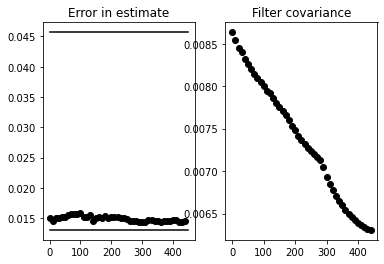

In [73]:
# # model error and covar plots
# fig, axs = plt.subplots(1, 2)

# axs[0].set_title('Error in estimate')
# axs[1].set_title('Filter covariance')

# true_params = mdl_datagen.to_vector()


# for i in tqdm(range(0, num_circs, plt_spacing)):
#     params = data_model_vectors[i]
#     error = np.sqrt( (params-true_params)@(params-true_params))
#     axs[0].scatter(i, error, c='black')
#     axs[1].scatter(i, np.sqrt(np.trace(data_covars[i])), c='black')
    
# MLE_error = np.sqrt( (mle_fit.to_vector()-true_params)@(mle_fit.to_vector()-true_params))
# linear_error = np.sqrt( (linear_fit.to_vector()-true_params)@(linear_fit.to_vector()-true_params))
# axs[0].plot((0, num_circs), (MLE_error, MLE_error), c='black')
# axs[0].plot((0, num_circs), (linear_error, linear_error), c='black')


In [187]:
# from matplotlib import cm
# %matplotlib inline
# # Model convergence plot 
# fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

# # plot the ideal params as colored lines
# ideal_params = mdl_datagen.to_vector()
# for idx, p in enumerate(ideal_params):
#     c = idx/len(ideal_params)
#     ax.plot((0, num_circs), (p, p), color=cm.get_cmap('gist_ncar')(c))

# for i in tqdm(range(0, num_circs, plt_spacing)):
#     params = data_model_vectors[i]
#     for idx, p in enumerate(params):
#         c = idx/len(params)
#         ax.scatter(i, p, color=cm.get_cmap('gist_ncar')(c))
#         ax.errorbar(i, p, yerr=np.sqrt(data_covars[i][idx, idx]), color=cm.get_cmap('gist_ncar')(c))
    
# params = data_model_vectors[num_circs-1]
# for idx, p in enumerate(params):
#     c = idx/len(params)
#     ax.scatter(num_circs-1, p, color=cm.get_cmap('gist_ncar')(c))
#     ax.errorbar(num_circs-1, p, yerr=np.sqrt(data_covars[i][idx, idx]), color=cm.get_cmap('gist_ncar')(c))
    
# ax.set_ylim([-0.001, 0.024])
# ax.set_title('Parameter convergence')
# ax.set_xlabel('Circuit index')
# ax.set_ylabel('Parameter magnitude')

  0%|                                                                                                                                                                                                                 | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_2438/3849024774.py:14: RuntimeWarning: invalid value encountered in log
  infidel = np.log(1 - avg_gs_fidelity(filter_model, mdl_datagen))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:19<00:00,  2.30it/s]


Text(0, 0.5, 'AGSI (log)')

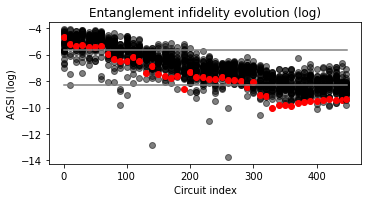

In [80]:
# # Infidelity convergence plot 
# num_samples = 32
    
# fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

# for i in tqdm(range(0, num_circs, plt_spacing)):
#     filter_model.from_vector(data_model_vectors[i])
#     mean_infidel = np.log(1 - avg_gs_fidelity(filter_model, mdl_datagen))
    
    
#     for s in range(num_samples):
#         x0 = np.random.multivariate_normal(data_model_vectors[i], data_covars[i])
#         filter_model.from_vector(x0)
#         infidel = np.log(1 - avg_gs_fidelity(filter_model, mdl_datagen))
#         plt.scatter(i, infidel, c='black', alpha=0.5)
        
#     ax.scatter(i, mean_infidel, c='red')
    
# i = num_circs-1
# filter_model.from_vector(data_model_vectors[i])
# mean_infidel = np.log(1 - avg_gs_fidelity(filter_model, mdl_datagen))

# for s in range(num_samples):
#     x0 = np.random.multivariate_normal(data_model_vectors[i], data_covars[i])
#     filter_model.from_vector(x0)
#     infidel = np.log(1 - avg_gs_fidelity(filter_model, mdl_datagen))
#     plt.scatter(i, infidel, c='black', alpha=0.5)

# ax.scatter(i, mean_infidel, c='red')
    
# mle_infidel = np.log(1-avg_gs_fidelity(mle_fit, mdl_datagen))
# ax.plot((0, num_circs), (mle_infidel, mle_infidel), c='gray')

# linear_infidel = np.log(1-avg_gs_fidelity(linear_fit, mdl_datagen))
# ax.plot((0, num_circs), (linear_infidel, linear_infidel), c='gray')


# ax.set_title('Entanglement infidelity evolution (log)')
# ax.set_xlabel('Circuit index')
# ax.set_ylabel('AGSI (log)')

In [86]:
# %matplotlib
# from matplotlib import cm
# plt_spacing = 10

# fig, axs = plt.subplots(6, 2)
# axs[0,0].set_title('Estimate errors')
# axs[0,1].set_title('Innovations')
# axs[1,0].set_title('Parameter estimate')
# axs[1,1].set_title('Jacobian error')
# axs[2,0].set_title('Total uncertainty (trace of covar)')
# axs[2,1].set_title('Total error in filter')
# axs[3,0].set_title('Total uncertainty (trace of covar) (log)')
# axs[3,1].set_title('Total error in filter (log)')
# axs[4,0].set_title('Prior innovation history')
# axs[4,1].set_title('Posterior innovation history')
# axs[5,0].set_title('AGSI (log)')
# axs[5,1].set_title('Kalman gain norm and difference (log)')
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)

# flg = 0

# true_params = mdl_datagen.to_vector()
# prior_innovs = []
# post_innovs = []
# prior_kgain = np.zeros((len(true_params), 2))

# total_circuit_len = sum([len(c) for c in edesign.circuit_lists])


# for circ_list in edesign.circuit_lists:
#     for circ in tqdm(circ_list):
#         counts = data.dataset[circ].counts
#         cvec = vector_from_outcomes(counts, 2**circ.width)
#         freq = cvec/sum(cvec)
        
#         p_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
#         prior_innov = freq - p_filter_prior    
#         prior_model_error = np.linalg.norm(mdl_datagen.to_vector() - ekf.model.to_vector())
            
#         kgain = ekf.update(circ, cvec, jdict[circ], hdict[circ], max_itr, max_itr_epsilon, None, None)

#         p_filter_post = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
#         post_innov = freq - p_filter_post

#         prior_innovs.append(prior_innov)
#         post_innovs.append(post_innov)
            
            
#         # plotting
#         if flg%plt_spacing == 0:
#             # innovations
#             axs[0,1].scatter(flg, prior_innov[0], c='red')
#             axs[0,1].scatter(flg, post_innov[0], c='green', alpha=0.5)
            
#             # evolution of the total model errors
#             post_model_error = np.linalg.norm(mdl_datagen.to_vector() - ekf.model.to_vector())
#             axs[2,1].scatter(flg, prior_model_error, c='red')
#             axs[2,1].scatter(flg, post_model_error, c='green')
#             axs[3,1].scatter(flg, np.log(prior_model_error), c='red')
#             axs[3,1].scatter(flg, np.log(post_model_error), c='green')
            
#             # evolution of specific parameter model errors
#             params = ekf.model.to_vector()
#             for idx, p in enumerate(params):
#                 axs[0, 0].scatter(idx, abs(true_params[idx] - params[idx]),  color=cm.get_cmap('inferno')(100*flg/total_circuit_len), alpha=0.5)
            
#             # filter uncertainty
#             P = ekf.P
#             axs[2,0].scatter(flg, np.sqrt(np.trace(P)), c='black')
#             axs[3,0].scatter(flg, np.log(np.sqrt(np.trace(P))), c='black')
            
#             # param tracker with error bars
#             params = ekf.model.to_vector()
#             for idx, p in enumerate(params):
#                 c = idx/len(params)
#                 axs[1,0].scatter(flg, p, color=cm.get_cmap('gist_ncar')(c))
#                 axs[1,0].errorbar(flg, p, yerr=np.sqrt(P[idx, idx]), color=cm.get_cmap('gist_ncar')(c))
                
#             # evolution of the Kgain 
#             axs[5, 1].scatter(flg, np.log(np.linalg.norm(prior_kgain - kgain)), c='black')
#             axs[5, 1].scatter(flg, np.log(np.linalg.norm(kgain)), c='blue')
            
#             # evolution of the agsi
#             agsf = avg_gs_fidelity(ekf.model, mdl_datagen)
#             axs[5, 0].scatter(flg, np.log(1-agsf), c='green')
            
#             # evolution of jacobian error
#             jtrue = matrix_from_jacob(ekf.model.sim.dprobs(circ), 2**circ.width)
#             japprox = jdict[circ] + ekf.model.to_vector()@hdict[circ]
#             jerror = np.linalg.norm(jtrue - japprox)/np.linalg.norm(japprox)
#             axs[1, 1].scatter(flg, jerror, c='black')
                
            
#         prior_kgain = kgain
#         flg += 1
        
# axs[0,1].plot((0, flg), (1/np.sqrt(samples), 1/np.sqrt(samples)), c='black')
# axs[0,1].plot((0, flg), (-1/np.sqrt(samples), -1/np.sqrt(samples)), c='black')

# true_params = mdl_datagen.to_vector()

# for idx, p in enumerate(true_params):
#     c = idx/len(true_params)
#     params = ekf.model.to_vector()
#     axs[0, 0].scatter(idx, abs(true_params[idx] - x0[idx]), c='magenta')
#     axs[0, 0].scatter(idx, abs(true_params[idx] - params[idx]), c='cyan')
    
# axs[4, 0].hist([p[0] for p in prior_innovs])
# axs[4, 1].hist([p[0] for p in post_innovs])

# plt.savefig('P01_abouttrue_Seed10.svg')

In [190]:
# # parameter distance plots
# bar_width = 0.4
# fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
# true_params = mdl_datagen.to_vector()

# for i in tqdm(range(0, num_circs, plt_spacing)):
#     params = data_model_vectors[i]
#     c = i/num_circs
#     for idx, p in enumerate(params):
#         ax.bar(idx, abs(p - true_params[idx]), bar_width, color=cm.get_cmap('cividis')(c))
        
# i = num_circs-1
# params = data_model_vectors[i]
# c = i/num_circs
# for idx, p in enumerate(params):
#     ax.bar(idx, abs(p - true_params[idx]), bar_width, color=cm.get_cmap('cividis')(c))

# for i in tqdm(range(0, num_circs, plt_spacing)):
#     params = data_model_vectors[i]
#     c = i/num_circs
#     for idx, p in enumerate(params):
#         ax.scatter(idx, abs(p - true_params[idx]), marker='s', color=cm.get_cmap('cividis')(c))
        
# i = num_circs-1
# params = data_model_vectors[i]
# c = i/num_circs
# for idx, p in enumerate(params):
#     ax.scatter(idx, abs(p - true_params[idx]), marker='s', color=cm.get_cmap('cividis')(c))
        
# mle_params = mle_fit.to_vector()
# for idx, p in enumerate(mle_params):
#     ax.plot((idx-0.25, idx+0.25), (abs(p - true_params[idx]), abs(p - true_params[idx])), c='red')
    
# ax.set_title('Distance from datagen model')
# ax.set_xlabel('Parameter index')
# ax.set_ylabel('Error magnitude')

In [89]:
%matplotlib qt5
plt.matshow(ekf.P)

In [25]:
avg_gs_fidelity(target_model, mdl_datagen)

0.9852445602865357

In [26]:
avg_gs_fidelity(filter_model, mdl_datagen)

0.9596020198729422

In [27]:
avg_gs_fidelity(ekf.model, mdl_datagen)

0.9999902408662896

In [28]:
# convert to TP model first
# model.set_parameterization?
#gauge_mdl = ekf.model.copy()
#gauge_mdl.set_all_parameterizations('CPTP')
#gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(ekf.model, target_model, item_weights={'gates': 1.0, 'spam': 0.1})
#avg_gs_fidelity(gauge_optimized_mdl, mdl_datagen)

In [29]:
avg_gs_fidelity(linear_fit, mdl_datagen)

0.9999928176693985

In [30]:
avg_gs_fidelity(mle_fit, mdl_datagen)

0.9999928176693985

In [ ]:
def likelihood(estimate):
    mdl = target_model.copy()
    mdl.from_vector(estimate)
    pout = 1
    for circ_list in edesign.circuit_lists:
        for circ in circ_list:
            pout *= vector_from_outcomes(mdl.probabilities(circ), 2**circ.width)
    return pout

In [158]:
# try using a Gaussian rv about the ideal point 
np.random.seed(10)

P = 0.01*np.eye(filter_model.num_params)

filter_model = target_model.copy()

max_itr = 20
max_itr_epsilon = 1e-6

x0 = np.abs(np.random.multivariate_normal(np.zeros(filter_model.num_params), P))
print(x0)

filter_model.from_vector(x0)

P0 = P
ekf = ExtendedKalmanFilter(filter_model.copy(), P)

[0.13315865 0.0715279  0.15454003 0.00083838 0.0621336  0.07200856
 0.02655116 0.01085485 0.00042914 0.01746002 0.04330262 0.12030374
 0.09650657 0.10282741 0.02286301 0.04451376 0.11366022 0.01351369]


In [159]:
print(mdl_datagen.to_vector())
print(np.linalg.norm(ekf.model.to_vector() - mdl_datagen.to_vector()))

[0.00191519 0.00622109 0.00437728 0.00785359 0.00779976 0.00272593
 0.00276464 0.00801872 0.00958139 0.00875933 0.00357817 0.00500995
 0.00683463 0.00712702 0.00370251 0.00561196 0.00503083 0.00013768]
0.3138526595528793


In [160]:
avg_gs_fidelity(filter_model, mdl_datagen)

0.9328572944033554

In [161]:
%matplotlib
from matplotlib import cm
plt_spacing = 10

fig, axs = plt.subplots(5, 2)
flg = 0

true_params = mdl_datagen.to_vector()
prior_innovs = []
post_innovs = []
prior_kgain = np.zeros((len(true_params), 2))

total_circuit_len = sum([len(c) for c in circ_list])


for circ_list in edesign.circuit_lists:
    for circ in tqdm(circ_list):
        counts = data.dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        freq = cvec/sum(cvec)
        
        p_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
        prior_innov = freq - p_filter_prior    
            
        kgain = ekf.update(circ, cvec, jdict[circ], hdict[circ], max_itr, max_itr_epsilon, None, None)

        p_filter_post = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
        post_innov = freq - p_filter_post

        prior_innovs.append(prior_innov)
        post_innovs.append(post_innov)
            
            
        # plotting
        if flg%plt_spacing == 0:
            # innovations
            axs[0,1].scatter(flg, prior_innov[0], c='red')
            axs[0,1].scatter(flg, post_innov[0], c='green', alpha=0.5)
            
            # evolution of the total model errors
            prior_model_error = np.linalg.norm(mdl_datagen.to_vector() - ekf.model.to_vector())
            post_model_error = np.linalg.norm(mdl_datagen.to_vector() - ekf.model.to_vector())
            axs[2,1].scatter(flg, prior_model_error, c='red')
            axs[2,1].scatter(flg, post_model_error, c='green')
            
            # evolution of specific parameter model errors
            params = ekf.model.to_vector()
            for idx, p in enumerate(params):
                axs[0, 0].scatter(idx, abs(true_params[idx] - params[idx]),  color=cm.get_cmap('inferno')(100*flg/total_circuit_len), alpha=0.5)
            flg2+= 1
            
            # param tracker with error bars
            params = ekf.model.to_vector()
            P = ekf.P
            axs[2,0].scatter(flg, np.sqrt(np.trace(P)), c='black')
            for idx, p in enumerate(params):
                c = idx/len(params)
                axs[1,0].scatter(flg, p, color=cm.get_cmap('gist_ncar')(c))
                axs[1,0].errorbar(flg, p, yerr=np.sqrt(P[idx, idx]), color=cm.get_cmap('gist_ncar')(c))
                
            # evolution of the Kgain 
            axs[4, 1].scatter(flg, np.linalg.norm(prior_kgain - kgain), c='black')
            axs[4, 1].scatter(flg, np.linalg.norm(kgain), c='blue')
            
            # evolution of the agsf
            agsf = avg_gs_fidelity(ekf.model, mdl_datagen)
            axs[4, 0].scatter(flg, agsf, c='green')
            
            # evolution of jacobian error
            jtrue = matrix_from_jacob(ekf.model.sim.dprobs(circ), 2**circ.width)
            japprox = jdict[circ] + ekf.model.to_vector()@hdict[circ]
            jerror = np.linalg.norm(jtrue - japprox)/np.linalg.norm(japprox)
            axs[1, 1].scatter(flg, jerror, c='black')
                
            
        prior_kgain = kgain
        flg += 1
        
axs[0,1].plot((0, flg), (1/np.sqrt(samples), 1/np.sqrt(samples)), c='black')
axs[0,1].plot((0, flg), (-1/np.sqrt(samples), -1/np.sqrt(samples)), c='black')

true_params = mdl_datagen.to_vector()

for idx, p in enumerate(true_params):
    c = idx/len(true_params)
    params = ekf.model.to_vector()
    axs[0, 0].scatter(idx, abs(true_params[idx] - x0[idx]), c='magenta')
    axs[0, 0].scatter(idx, abs(true_params[idx] - params[idx]), c='cyan')
    
axs[3, 0].hist([p[0] for p in prior_innovs])
axs[3, 1].hist([p[0] for p in post_innovs])

plt.savefig('P01_aboutzero_Seed10.svg')

Using matplotlib backend: QtAgg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [08:02<00:00,  1.08s/it]


In [162]:
plt.matshow(ekf.P)

In [163]:
avg_gs_fidelity(target_model, mdl_datagen)

0.9852445602865357

In [164]:
avg_gs_fidelity(filter_model, mdl_datagen)

0.9328572944033554

In [165]:
avg_gs_fidelity(ekf.model, mdl_datagen)

0.9999901126514191

In [166]:
gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(ekf.model, target_model, item_weights={'gates': 1.0, 'spam': 0.1})
avg_gs_fidelity(gauge_optimized_mdl, mdl_datagen)

0.9999901126514191

In [167]:
avg_gs_fidelity(linear_fit, mdl_datagen)

0.9999928176693985

In [168]:
avg_gs_fidelity(mle_fit, mdl_datagen)

0.9999928176693985

# Error Gen Analysis

In [293]:
ar

array([0.00191519, 0.00622109, 0.00437728, 0.00785359, 0.00779976,
       0.00272593, 0.00276464, 0.00801872, 0.00958139, 0.00875933,
       0.00357817, 0.00500995, 0.00683463, 0.00712702, 0.00370251,
       0.00561196, 0.00503083, 0.00013768])

In [296]:
print(mdl_datagen)

rho0 = <pygsti.modelmembers.states.composedstate.ComposedState object at 0x7f5181151fc0>

Mdefault = Lindblad-parameterized POVM of length 2


[] = 
Composed operation of 2 factors:
Factor 0:
StaticUnitaryOp with shape (2, 2)
 1.00   0
   0 1.00
Factor 1:
Exponentiated operation map with dim = 4, num params = 6


Gxpi2:0 = 
Composed operation of 2 factors:
Factor 0:
StaticUnitaryOp with shape (2, 2)
 0.71  +0j   0-0.71j
   0-0.71j 0.71  +0j
Factor 1:
Exponentiated operation map with dim = 4, num params = 6


Gypi2:0 = 
Composed operation of 2 factors:
Factor 0:
StaticUnitaryOp with shape (2, 2)
 0.71-0.71
 0.71 0.71
Factor 1:
Exponentiated operation map with dim = 4, num params = 6






In [316]:
Gx = gst_mdl[('Gxpi2', 0)]

In [327]:
Gx.num_params

6

In [317]:
Gx?

Type:           ComposedOp
String form:   
Composed operation of 2 factors:
Factor 0:
StaticUnitaryOp with shape (2, 2)
 0.71  +0j   0-0.71j
   0-0.71j 0.71  +0j
Factor 1:
Exponentiated operation map with dim = 4, num params = 6
File:           ~/Applications/pyGSTi/pygsti/modelmembers/operations/composedop.py
Docstring:     
An operation that is the composition of a number of map-like factors (possibly other `LinearOperator`s).

Parameters
----------
ops_to_compose : list
    List of `LinearOperator`-derived objects
    that are composed to form this operation map.  Elements are composed
    with vectors  in  *left-to-right* ordering, maintaining the same
    convention as operation sequences in pyGSTi.  Note that this is
    *opposite* from standard matrix multiplication order.

evotype : Evotype or str, optional
    The evolution type.  The special value `"default"` is equivalent
    to specifying the value of `pygsti.evotypes.Evotype.default_evotype`.
    The special value `"auto"`

In [318]:
Gideal, E = Gx.submembers()

In [319]:
print(E)

Exponentiated operation map with dim = 4, num params = 6



In [320]:
E?

Type:           ExpErrorgenOp
String form:    Exponentiated operation map with dim = 4, num params = 6
File:           ~/Applications/pyGSTi/pygsti/modelmembers/operations/experrorgenop.py
Docstring:     
An operation parameterized by the coefficients of an exponentiated sum of Lindblad-like terms.
TODO: update docstring!

The exponentiated terms give the operation's action.

Parameters
----------
errorgen : LinearOperator
    The error generator for this operator.  That is, the `L` if this
    operator is `exp(L)`.
Init docstring: Initialize a new LinearOperator 


In [321]:
print(E.errorgen)

Lindblad error generator with dim = 4, num params = 6



In [322]:
E?

Type:           ExpErrorgenOp
String form:    Exponentiated operation map with dim = 4, num params = 6
File:           ~/Applications/pyGSTi/pygsti/modelmembers/operations/experrorgenop.py
Docstring:     
An operation parameterized by the coefficients of an exponentiated sum of Lindblad-like terms.
TODO: update docstring!

The exponentiated terms give the operation's action.

Parameters
----------
errorgen : LinearOperator
    The error generator for this operator.  That is, the `L` if this
    operator is `exp(L)`.
Init docstring: Initialize a new LinearOperator 


In [323]:
E.parameter_labels

array(['X Hamiltonian error coefficient',
       'Y Hamiltonian error coefficient',
       'Z Hamiltonian error coefficient', 'X stochastic coefficient',
       'Y stochastic coefficient', 'Z stochastic coefficient'],
      dtype=object)

In [326]:
gauge_basis.labels

(('H', ('X',), (0,)),
 ('H', ('Y',), (0,)),
 ('H', ('Z',), (0,)),
 ('S', ('X',), (0,)),
 ('S', ('Y',), (0,)),
 ('S', ('Z',), (0,)))